# Cat Dog Classification Transfer Learning

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms  # Import the updated torchvision transforms (version 2)
from torchvision import models # To get pre-trained models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

We will create two datasets. One is unbalanced (when our dataset is balanced) for testing and validation. The other is balanced for training (here we have a different amount of data in two classes, so we need to balance it via a dataset).

First dataset is unbalanced. It is enough to give a path to images and it will load them and decide on their labels.

In [2]:
class ImageAugmentationDatasetUnbalanced(Dataset):
    """
    A custom PyTorch Dataset class that loads images from a directory,
    applies a series of augmentations to each image, and returns the augmented images and their labels.
    This class is designed to simulate an infinite dataset by wrapping around the dataset indices.
    """

    def __init__(self, image_dir, image_size=(128, 128), is_training=True):
        """
        Initializes the dataset by listing all image files in the specified directory
        and assigning labels based on the filename.

        Args:
            image_dir (str): The directory containing the image files.
            image_size (tuple): The desired output size of the images (width, height).
        """
        self.image_dir = image_dir  # Store the path to the image directory
        self.image_size = image_size  # Store the desired image size
        self.is_training = is_training

        # List comprehension to gather all image files with specified extensions
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith(('.png', '.jpg', '.jpeg'))
        ]
        # Now, self.image_files contains all the image filenames in the directory

        # Assign labels based on the first character of the filename
        # 1 for "cats" (capital letter), 0 for "dogs" (small letter)
        self.labels = [
            1 if f[0].isupper() else 0 for f in self.image_files
        ]

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of image files found in the directory.
        """
        return len(self.image_files)  # Return the total count of image files

    def augment(self, image):
        """
        Applies a sequence of augmentation transforms to the input image.

        Args:
            image (PIL.Image.Image): The input image to be augmented.

        Returns:
            torch.Tensor: The augmented image as a tensor.
        """
        # Calculate the minimum size for resizing to ensure the image is large enough after cropping
        min_size = max(self.image_size) + 40  # Add padding (40 pixels) to the largest dimension

        # Normalization (commented out if not needed)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        # Compose a sequence of augmentation transforms
        aug_transforms = transforms.Compose([
            transforms.Resize((min_size, min_size)),  # Resize the image to at least min_size
            transforms.RandomCrop(size=self.image_size),  # Randomly crop to the desired size
            #transforms.RandomVerticalFlip(),  # Randomly flip the image vertically (Up/Down) with a 50% chance (disabled as we do not expect upsidedown images)
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (Left/Right) with a 50% chance
            transforms.ColorJitter(
                brightness=0.2,  # Adjust brightness by a factor of ±0.5
                contrast=0.2     # Adjust contrast by a factor of ±0.5
            ),
            transforms.RandomAffine(
                degrees=10,              # Rotate the image randomly within ±10 degrees
                scale=(0.7, 1.3),        # Randomly scale the image
                translate=(0.1, 0.1)     # Translate the image randomly by up to 10% in both directions
            ),
            
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Transforms for evaluation mode
        out_transforms = transforms.Compose([
            transforms.Resize(self.image_size),  # Resize to the desired size
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Apply the composed transforms to the image
        if self.is_training:
            augmented_image = aug_transforms(image)
            return augmented_image  # Return the augmented image tensor
        else:
            output_image = out_transforms(image)
            return output_image  # Return the processed image tensor

    def __getitem__(self, idx):
        """
        Retrieves an augmented image and its label based on the given index.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: A tuple containing the augmented image tensor and its label.
        """
        # Wrap around the dataset indices using modulo to handle infinite indices
        real_idx = idx % len(self.image_files)
        # Construct the full path to the image file
        img_path = os.path.join(self.image_dir, self.image_files[real_idx])
        # Open the image and convert it to RGB mode to ensure consistency
        image = Image.open(img_path).convert('RGB')
        # Apply augmentations to the image
        augmented_image = self.augment(image)
        # Retrieve the label for the current image
        label = self.labels[real_idx]
        return augmented_image, label  # Return the augmented image and its label

Another dataset is balanced. For it we need to supply two lists with paths to images for each class. This dataset will alternate between supplied lists and read files. When the shorter list is empty, it will start over that list.

In [3]:
class ImageAugmentationDatasetBalanced(Dataset):
    """
    A custom PyTorch Dataset class that loads images from a given lists,
    applies a series of augmentations to each image, and returns the augmented images and their labels.
    This class ensures class balancing between 'cats' and 'dogs' by alternating between classes
    (even indices return one class, odd indices return the other).
    """
    
    def __init__(self, class0_files, class1_files, image_size=(128, 128), is_training=True):
        """
        Initializes the dataset by listing all image files in the specified directory,
        assigning labels based on the filename, and separating the images into two classes.

        Args:
            class0_files (list): List containing the image files for class0.
            class1_files (list): List containing the image files for class1.
            image_size (tuple): The desired output size of the images (width, height).
            is_training (bool): Switch on augmentation of dataset if True.
        """
        
        self.image_size = image_size  # Store the desired image size
        self.is_training = is_training  # Flag indicating training or evaluation mode

        # Initialize lists to store filenames for each class
        self.class0_files = class0_files  # Class 0 (e.g., dogs)
        self.class1_files = class1_files  # Class 1 (e.g., cats)

        # Store the lengths of each class list for later use
        self.len_class0 = len(self.class0_files)
        self.len_class1 = len(self.class1_files)

    def __len__(self):
        """
        If returns a number of max(samples one class, samples other class) * 2

        Returns:
            int: A number representing the dataset length.
        """
        return max(self.len_class0, self.len_class1) * 2

    def augment(self, image):
        """
        Applies a sequence of augmentation transforms to the input image.

        Args:
            image (PIL.Image.Image): The input image to be augmented.

        Returns:
            torch.Tensor: The augmented image as a tensor.
        """
        # Calculate the minimum size for resizing to ensure the image is large enough after cropping
        min_size = max(self.image_size) + 40  # Add padding (40 pixels) to the largest dimension

        # Normalization (commented out if not needed)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        # Compose a sequence of augmentation transforms
        aug_transforms = transforms.Compose([
            transforms.Resize((min_size, min_size)),  # Resize the image to at least min_size
            transforms.RandomCrop(size=self.image_size),  # Randomly crop to the desired size
            #transforms.RandomVerticalFlip(),  # Randomly flip the image vertically (Up/Down) with a 50% chance (disabled as we do not expect upsidedown images)
            transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally (Left/Right) with a 50% chance
            
            transforms.ColorJitter(
                brightness=0.2,  # Adjust brightness by a factor of ±0.5
                contrast=0.2     # Adjust contrast by a factor of ±0.5
            ),
            transforms.RandomAffine(
                degrees=10,              # Rotate the image randomly within ±10 degrees
                scale=(0.7, 1.3),        # Randomly scale the image
                translate=(0.1, 0.1)     # Translate the image randomly by up to 10% in both directions
            ),
            
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Transforms for evaluation mode
        out_transforms = transforms.Compose([
            transforms.Resize(self.image_size),  # Resize to the desired size
            transforms.ToImage(),  # Ensure the output is a PIL Image
            transforms.ToDtype(torch.float32, scale=True),  # Convert to float32 tensor and scale pixel values to [0, 1]
            normalize, # Normalize by subtracting mean and dividing by std. deviation (expect negative and positive values)
        ])

        # Apply the composed transforms to the image
        if self.is_training:
            augmented_image = aug_transforms(image)
            return augmented_image  # Return the augmented image tensor
        else:
            output_image = out_transforms(image)
            return output_image  # Return the processed image tensor

    def __getitem__(self, idx):
        """
        Retrieves an augmented image and its label based on the given index,
        ensuring class balancing by alternating between classes.

        Args:
            idx (int): The index of the image to retrieve.

        Returns:
            tuple: A tuple containing the augmented image tensor and its label.
        """
        # Determine which class to sample from based on the index parity
        if idx % 2 == 0:
            # Even index: sample from class 0 (e.g., dogs)
            class_files = self.class0_files
            label = 0
            class_len = self.len_class0
        else:
            # Odd index: sample from class 1 (e.g., cats)
            class_files = self.class1_files
            label = 1
            class_len = self.len_class1

        # Compute the index within the class list, wrapping around if necessary
        class_idx = (idx // 2) % class_len

        # Get the filename of the image
        filename = class_files[class_idx]

        # Construct the full path to the image file
        #img_path = os.path.join(self.image_dir, filename)

        # Open the image and convert it to RGB mode to ensure consistency
        image = Image.open(filename).convert('RGB')

        # Apply augmentations to the image
        augmented_image = self.augment(image)

        # print(torch.min(augmented_image).item())
        # print(torch.max(augmented_image).item())
        
        return augmented_image, label  # Return the augmented image and its label


This function will help us read all images and separate them into two lists (one for each class). This function is useful to prepare data for `ImageAugmentationDatasetBalanced`.

In [4]:
def separate_image_files_by_class(image_dir):
    """
    Separates image files in the given directory into two classes based on the first character of the filename.

    Class 0: Filenames starting with a lowercase letter.
    Class 1: Filenames starting with an uppercase letter.

    Parameters:
        image_dir (str): The directory containing image files.

    Returns:
        class0_files (list): List of filenames for class 0. Full paths.
        class1_files (list): List of filenames for class 1. Full paths.
    """

    # List comprehension to gather all image files with specified extensions
    all_image_files = [
        f for f in os.listdir(image_dir)
        if f.endswith(('.png', '.jpg', '.jpeg'))
    ]

    # Initialize lists to store filenames for each class
    class0_files = []  # Class 0 (e.g., dogs, lowercase)
    class1_files = []  # Class 1 (e.g., cats, uppercase)

    # Separate the image files into two classes based on the first character of the filename
    for f in all_image_files:
        if f[0].isupper():
            class1_files.append(os.path.join(image_dir, f))  # Capital letter indicates class 1
        else:
            class0_files.append(os.path.join(image_dir, f))  # Small letter indicates class 0

    return class0_files, class1_files

We will use already trained model with ImageNet weights and replace the classification layer to our 2 classes.

In [5]:
class PretrainedNetwork(nn.Module):
    def __init__(self, num_classes=2):
        super(PretrainedNetwork, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Replace the last layer
        num_ftrs = self.model.fc.in_features # get number of features of previous layer
        self.model.fc = nn.Linear(num_ftrs, num_classes) # set number of output to 2 (our number of classes)

    def forward(self, x):
        return self.model(x)

In [6]:
# Training parameters
batch_size = 64
num_epochs = 30
images_path = "./train_images"
images_test_path = "./test_images"
image_size=(128, 128)
best_model_path = "best_model_transfer_learning.pth"

In [7]:
# Separate files into classes
class0_files, class1_files = separate_image_files_by_class(images_path)

# Get 10% of length of one containing less files
validation_len = int(min(len(class0_files), len(class1_files)) * 0.1)

# Randomly sample validation_len files from each class
validation_class0_files = random.sample(class0_files, validation_len)
validation_class1_files = random.sample(class1_files, validation_len)

# The remaining files from each class (by set difference)
training_class0_files = list(set(class0_files) - set(validation_class0_files))
training_class1_files = list(set(class1_files) - set(validation_class1_files))

# Create an instance of the dataset with the path to the image directory
train_dataset = ImageAugmentationDatasetBalanced(training_class0_files, training_class1_files, image_size=image_size, is_training=True)
validation_dataset = ImageAugmentationDatasetBalanced(validation_class0_files, validation_class1_files, image_size=image_size, is_training=False)
test_dataset = ImageAugmentationDatasetUnbalanced(images_test_path, image_size=image_size, is_training=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image_tensor * std + mean
    
def display_batch(batch, limit_to=4):
    """
    Displays a batch of images in a single row using matplotlib, with class labels as titles.

    Args:
        batch (tuple): A batch of data returned by DataLoader, in the form (images, labels), where:
            - images (torch.Tensor): Tensor of shape (batch_size, channels, height, width).
            - labels (torch.Tensor): Tensor of shape (batch_size,) containing class labels.
        limit_to (int): If batch is large, you can limit it to a given number of pictures
    """
    images, labels = batch
    batch_size = min(len(images), limit_to)
    fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))

    # If batch_size is 1, axes is not an array; make it a list for consistency
    if batch_size == 1:
        axes = [axes]

    # Loop over each image and its class label in the batch
    for i, (img, cls) in enumerate(zip(images, labels)):
        # Skip the rest of batch if limit reached
        if i >= limit_to:
            continue
        # Denormalize first, so pyplot can display this image
        img = denormalize(img)
        # Rearrange the image tensor for plotting
        img = img.permute(1, 2, 0)
        # Convert tensor to NumPy array and handle normalization if necessary
        img = img.cpu().numpy()
        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')
        # Set the class label as the title
        axes[i].set_title(str(cls.item()) if hasattr(cls, 'item') else str(cls))

    plt.tight_layout()
    plt.show()

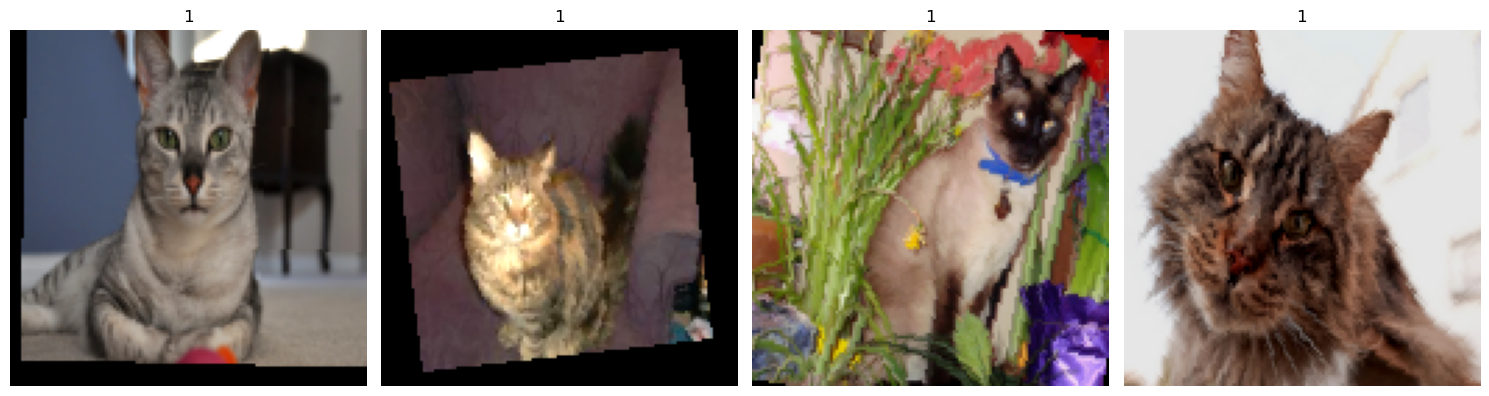

In [9]:
# Retrieve a single batch from the dataloader
batch = next(iter(train_loader))
# Display the batch of images
display_batch(batch)

In [10]:
# Instantiate the model
model = PretrainedNetwork()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

D:\Other\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Other\Anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PretrainedNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Now we can define loss, choose optimizer, scheduler and run training.

In [11]:
# Training

# Define the loss function (Cross-Entropy Loss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (AdamW optimizer with an initial learning rate)
optimizer = optim.AdamW(model.parameters(), lr=0.0001) # sgd, rmsprop, ...
# optimizer = optim.RMSprop(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a learning rate scheduler to decrease the learning rate by a factor of 0.98 each epoch
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

# Initialize lists to store training and validation losses and accuracies for analysis
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize the best validation loss to infinity for model saving purposes
best_val_loss = float('inf')

# Training loop for the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (enables dropout, batch normalization, etc.)
    running_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for a progress bar during training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False, ascii=True)
    for images, labels in train_loader_tqdm:
        # Move images and labels to the specified device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation

        outputs = model(images)          # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels)  # Compute the loss

        loss.backward()  # Backward pass: compute gradients
        # Clip gradients to prevent exploding gradients in deep networks
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update parameters based on gradients

        running_loss += loss.item()  # Accumulate the running loss

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)    # Get the index of the max log-probability
        total += labels.size(0)                      # Increment the total number of samples
        correct += (predicted == labels).sum().item()  # Increment correct predictions

        # Update the progress bar with the current loss
        train_loader_tqdm.set_postfix({'Loss': f'{loss.item():8.4f}'})

    # Calculate average loss and accuracy over the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)        # Append training loss for plotting
    train_accuracies.append(epoch_accuracy)  # Append training accuracy for plotting

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:8.4f}, Accuracy: {epoch_accuracy:6.2f}%')

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    val_loss = 0.0
    correct = 0
    total = 0

    # Use tqdm for a progress bar during validation
    validation_loader_tqdm = tqdm(validation_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False, ascii=True)
    with torch.no_grad():  # Disable gradient computation for validation
        for images, labels in validation_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)          # Forward pass: compute predicted outputs
            loss = criterion(outputs, labels)  # Compute the loss
            val_loss += loss.item()          # Accumulate validation loss

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)                    # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Increment correct predictions

            # Update the progress bar with the current loss
            validation_loader_tqdm.set_postfix({'Loss': f'{loss.item():8.4f}'})

    # Calculate average validation loss and accuracy over the epoch
    val_epoch_loss = val_loss / len(validation_loader)
    val_losses.append(val_epoch_loss)         # Append validation loss for plotting
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)       # Append validation accuracy for plotting

    print(f'Validation Loss: {val_epoch_loss:8.4f}, Accuracy: {val_accuracy:6.2f}%\n')

    # Save the model if validation loss has decreased (improved)
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model parameters
        print(f'Model saved with validation loss: {best_val_loss:8.4f}')

    # Update the learning rate using the scheduler
    scheduler.step()

    # Optionally, print the updated learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Learning rate adjusted to: {current_lr:.7f}')

Epoch 1/30, Training Loss:   0.1553, Accuracy:  93.29%


Validation Loss:   0.1082, Accuracy:  95.79%

Model saved with validation loss:   0.1082
Learning rate adjusted to: 0.0000980


Epoch 2/30, Training Loss:   0.0637, Accuracy:  97.47%


Validation Loss:   0.1156, Accuracy:  95.79%

Learning rate adjusted to: 0.0000960


Epoch 3/30, Training Loss:   0.0572, Accuracy:  97.80%


Validation Loss:   0.1520, Accuracy:  96.05%

Learning rate adjusted to: 0.0000941


Epoch 4/30, Training Loss:   0.0434, Accuracy:  98.49%


Validation Loss:   0.0575, Accuracy:  97.11%

Model saved with validation loss:   0.0575
Learning rate adjusted to: 0.0000922


Epoch 5/30, Training Loss:   0.0457, Accuracy:  98.38%


Validation Loss:   0.1172, Accuracy:  94.74%

Learning rate adjusted to: 0.0000904


Epoch 6/30, Training Loss:   0.0293, Accuracy:  98.99%


Validation Loss:   0.1314, Accuracy:  96.05%

Learning rate adjusted to: 0.0000886


Epoch 7/30, Training Loss:   0.0300, Accuracy:  98.94%


Validation Loss:   0.1365, Accuracy:  96.32%

Learning rate adjusted to: 0.0000868


Epoch 8/30, Training Loss:   0.0254, Accuracy:  99.21%


Validation Loss:   0.0714, Accuracy:  97.37%

Learning rate adjusted to: 0.0000851


Epoch 9/30, Training Loss:   0.0247, Accuracy:  99.12%


Validation Loss:   0.0810, Accuracy:  96.84%

Learning rate adjusted to: 0.0000834


Epoch 10/30, Training Loss:   0.0181, Accuracy:  99.38%


Validation Loss:   0.1247, Accuracy:  95.26%

Learning rate adjusted to: 0.0000817


Epoch 11/30, Training Loss:   0.0223, Accuracy:  99.16%


Validation Loss:   0.0960, Accuracy:  96.32%

Learning rate adjusted to: 0.0000801


Epoch 12/30, Training Loss:   0.0190, Accuracy:  99.44%


Validation Loss:   0.1485, Accuracy:  96.84%

Learning rate adjusted to: 0.0000785


Epoch 13/30, Training Loss:   0.0159, Accuracy:  99.49%


Validation Loss:   0.2250, Accuracy:  94.21%

Learning rate adjusted to: 0.0000769


Epoch 14/30, Training Loss:   0.0180, Accuracy:  99.38%


Validation Loss:   0.0745, Accuracy:  96.84%

Learning rate adjusted to: 0.0000754


Epoch 15/30, Training Loss:   0.0138, Accuracy:  99.49%


Validation Loss:   0.2336, Accuracy:  95.26%

Learning rate adjusted to: 0.0000739


Epoch 16/30, Training Loss:   0.0164, Accuracy:  99.47%


Validation Loss:   0.1278, Accuracy:  95.79%

Learning rate adjusted to: 0.0000724


Epoch 17/30, Training Loss:   0.0109, Accuracy:  99.63%


Validation Loss:   0.1804, Accuracy:  95.79%

Learning rate adjusted to: 0.0000709


Epoch 18/30, Training Loss:   0.0099, Accuracy:  99.63%


Validation Loss:   0.1144, Accuracy:  96.58%

Learning rate adjusted to: 0.0000695


Epoch 19/30, Training Loss:   0.0132, Accuracy:  99.58%


Validation Loss:   0.1125, Accuracy:  97.11%

Learning rate adjusted to: 0.0000681


Epoch 20/30, Training Loss:   0.0124, Accuracy:  99.58%


Validation Loss:   0.2036, Accuracy:  95.53%

Learning rate adjusted to: 0.0000668


Epoch 21/30, Training Loss:   0.0121, Accuracy:  99.59%


Validation Loss:   0.1049, Accuracy:  97.11%

Learning rate adjusted to: 0.0000654


Epoch 22/30, Training Loss:   0.0067, Accuracy:  99.78%


Validation Loss:   0.1000, Accuracy:  97.11%

Learning rate adjusted to: 0.0000641


Epoch 23/30, Training Loss:   0.0103, Accuracy:  99.67%


Validation Loss:   0.1544, Accuracy:  97.11%

Learning rate adjusted to: 0.0000628


Epoch 24/30, Training Loss:   0.0109, Accuracy:  99.72%


Validation Loss:   0.1182, Accuracy:  98.16%

Learning rate adjusted to: 0.0000616


Epoch 25/30, Training Loss:   0.0070, Accuracy:  99.74%


Validation Loss:   0.2645, Accuracy:  95.79%

Learning rate adjusted to: 0.0000603


Epoch 26/30, Training Loss:   0.0098, Accuracy:  99.67%


Validation Loss:   0.1223, Accuracy:  97.37%

Learning rate adjusted to: 0.0000591


Epoch 27/30, Training Loss:   0.0076, Accuracy:  99.70%


Validation Loss:   0.1537, Accuracy:  96.05%

Learning rate adjusted to: 0.0000580


Epoch 28/30, Training Loss:   0.0087, Accuracy:  99.64%


Validation Loss:   0.2604, Accuracy:  95.26%

Learning rate adjusted to: 0.0000568


Epoch 29/30, Training Loss:   0.0119, Accuracy:  99.65%


Validation Loss:   0.2562, Accuracy:  94.74%

Learning rate adjusted to: 0.0000557


Epoch 30/30, Training Loss:   0.0046, Accuracy:  99.84%


Validation Loss:   0.1438, Accuracy:  97.11%

Learning rate adjusted to: 0.0000545


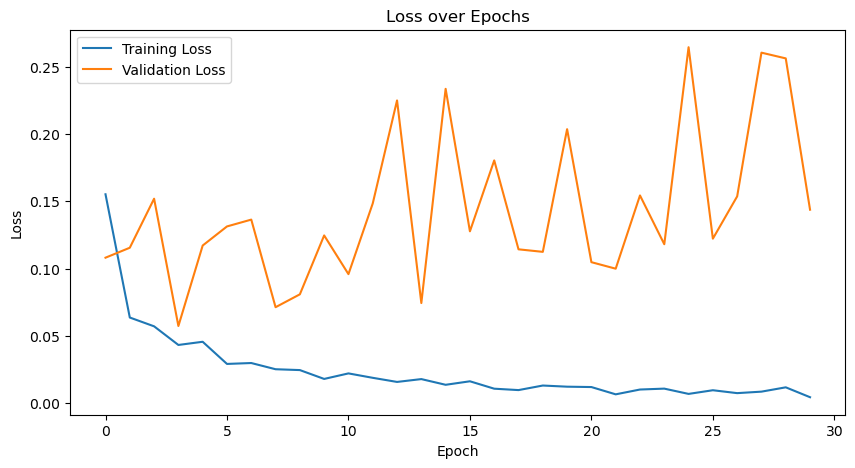

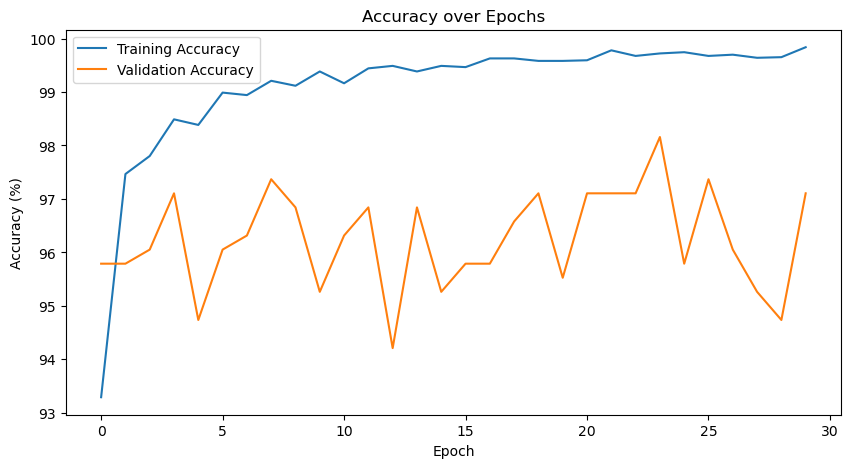

In [12]:
# Plotting Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [13]:
# Load the best model
if os.path.exists(best_model_path):
    print(f"Loading model from {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))

Loading model from best_model_transfer_learning.pth


In [14]:
# Set the model to evaluation mode (disable dropout, batch normalization, etc.)
model.eval()

# Initialize variables to track the test loss, correct predictions, and total samples
test_loss = 0.0
correct = 0
total = 0

# Initialize a list to store wrong predictions for visualization later
wrong_predictions = []

# Use the tqdm progress bar for the test set
test_loader_tqdm = tqdm(test_loader, desc="[Testing]", leave=False, ascii=True)
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: compute predicted outputs
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the predicted labels by selecting the class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)  # Update the total number of samples
        correct += (predicted == labels).sum().item()  # Increment correct predictions

        # Collect wrong predictions for visualization
        for img, pred, true_label in zip(images, predicted, labels):
            if pred != true_label:  # If prediction is wrong
                wrong_predictions.append((img.cpu(), pred.cpu(), true_label.cpu()))

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0997, Accuracy: 96.69%


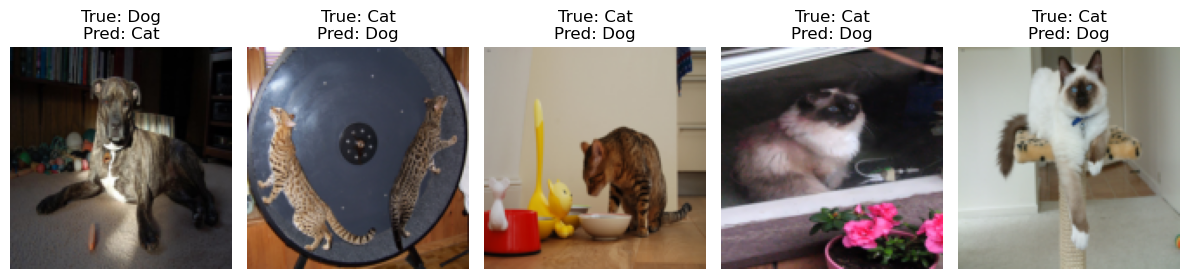

In [15]:
# Function to display images, predictions, and true labels
def show_wrong_predictions(wrong_predictions, class_names, num_images=5):
    plt.figure(figsize=(12, 6))
    
    # Display a few wrong predictions
    for i, (img, pred, true_label) in enumerate(wrong_predictions[:num_images]):
        img = denormalize(img) # Denormalize for display
        img = img.permute(1, 2, 0)  # Change the shape from [C, H, W] to [H, W, C] for visualization
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy())
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# `class_names` maps class indices to class names
class_names = ['Dog', 'Cat']
show_wrong_predictions(wrong_predictions, class_names, num_images=5)  # Visualize 5 wrong predictions